In [1]:
#import libraries
import pandas as pd
from pandas import DataFrame 
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from pylab import rcParams

from numpy import log

from io import StringIO
import time, json

rcParams['figure.figsize'] = 18,10

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#retrieve data
def GetData(fileName):
    return pd.read_csv(fileName, header=0,usecols=['Date','Adj Close'], parse_dates=True, index_col='Date')

In [3]:
data_ivv = GetData('Asset_Dataset/IVV.csv')
data_ivv = data_ivv.dropna()
data_ivv.head()


,Adj Close
Date,
2014-06-02,176.640778
2014-06-09,175.508820
2014-06-16,177.934479
2014-06-23,177.215759
2014-06-30,180.068802


In [4]:
data_ivv.columns = ['IVV adjusted close']

In [5]:
data_ivv.head()

,IVV adjusted close
Date,
2014-06-02,176.640778
2014-06-09,175.508820
2014-06-16,177.934479
2014-06-23,177.215759
2014-06-30,180.068802


In [6]:
#Statistical info on IVV
data_ivv.describe()

,IVV adjusted close
count,261.000000
mean,223.273405
std,36.881681
min,172.080475
25%,191.549255
50%,210.913879
75%,260.477875
max,294.202942


In [7]:
#scale IVV data

scaler = MinMaxScaler()
scaled_ivv = scaler.fit_transform(data_ivv)
print(scaled_ivv)
%store scaled_ivv

[[0.03734205]
 [0.02807301]
 [0.04793552]
 [0.04205028]
 [0.06541243]
 [0.05351401]
 [0.0612001 ]
 [0.06171725]
 [0.02276902]
 [0.02816447]
 [0.04701016]
 [0.07243355]
 [0.08351969]
 [0.08699308]
 [0.07258162]
 [0.09024482]
 [0.06378675]
 [0.05977271]
 [0.01507256]
 [0.        ]
 [0.0587329 ]
 [0.09816093]
 [0.11130382]
 [0.11739222]
 [0.13565817]
 [0.13966795]
 [0.14605347]
 [0.09266616]
 [0.14286046]
 [0.1490978 ]
 [0.13402361]
 [0.12596243]
 [0.10618176]
 [0.13148595]
 [0.0902828 ]
 [0.13566566]
 [0.1679866 ]
 [0.17888445]
 [0.17492839]
 [0.15081856]
 [0.13805452]
 [0.17970584]
 [0.13678556]
 [0.14910555]
 [0.17663041]
 [0.16110554]
 [0.18900549]
 [0.18180533]
 [0.18863028]
 [0.19523021]
 [0.19935558]
 [0.18525535]
 [0.1748303 ]
 [0.1764806 ]
 [0.18728061]
 [0.17468036]
 [0.16399294]
 [0.16550116]
 [0.20313309]
 [0.16897006]
 [0.18789947]
 [0.16844228]
 [0.17937749]
 [0.09023707]
 [0.10283156]
 [0.05139879]
 [0.08352556]
 [0.08073501]
 [0.05283143]
 [0.07782163]
 [0.12658379]
 [0.14

In [8]:
#Change datasets to DataFrame
data_ivv_df = pd.DataFrame(data_ivv)
scaled_ivv_df = pd.DataFrame(scaled_ivv)

In [9]:
data_ivv_df.index

DatetimeIndex(['2014-06-02', '2014-06-09', '2014-06-16', '2014-06-23',
               '2014-06-30', '2014-07-07', '2014-07-14', '2014-07-21',
               '2014-07-28', '2014-08-04',
               ...
               '2019-03-25', '2019-04-01', '2019-04-08', '2019-04-15',
               '2019-04-22', '2019-04-29', '2019-05-06', '2019-05-13',
               '2019-05-20', '2019-05-27'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

Text(0.5, 1.0, 'IVV Autocorrelation Plot')

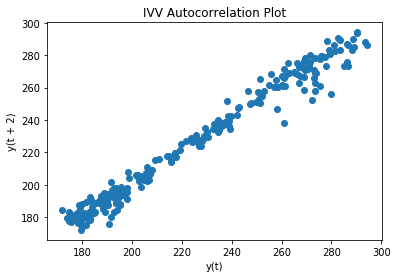

In [10]:
#analyze autocorr plot to see if ARIMA is necessary
#https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a

plt.figure()
lag_plot(data_ivv_df, lag=2)
plt.title('IVV Autocorrelation Plot')

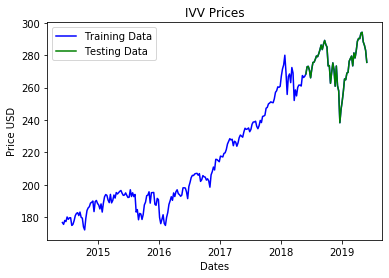

In [11]:
#Divide data into training and testing
train_data, test_data = data_ivv_df[0:int(len(data_ivv_df)*0.8)], data_ivv_df[int(len(data_ivv_df)*0.8):]
#plt.figure(figsize=(12,7))
plt.title('IVV Prices')
plt.xlabel('Dates')
plt.ylabel('Price USD')
plt.plot(data_ivv_df['IVV adjusted close'], 'blue', label='Training Data')
plt.plot(test_data['IVV adjusted close'], 'green', label='Testing Data')
#plt.xticks(np.arange(0,7982, 1300), data_ivv_df['Date'][0:7982:1300])
plt.legend()

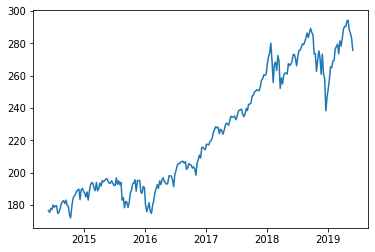

In [12]:
plt.plot(data_ivv_df)

In [13]:
train_ar = train_data['IVV adjusted close'].values
test_ar = test_data['IVV adjusted close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)

<class 'list'>
Testing Mean Squared Error: 37.702


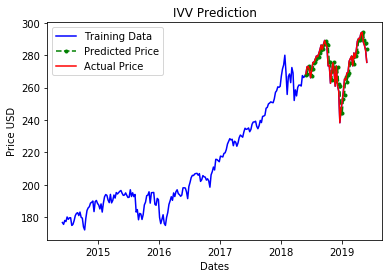

In [14]:
plt.plot(data_ivv_df['IVV adjusted close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='.', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['IVV adjusted close'], color='red', label='Actual Price')
plt.title('IVV Prediction')
plt.xlabel('Dates')
plt.ylabel('Price USD')
plt.legend()

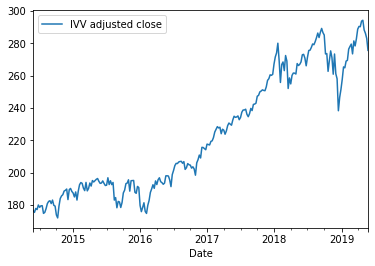

In [15]:
#Plot
data_ivv.plot()

In [16]:
scaled_ivv_df.head()

,0
0,0.037342
1,0.028073
2,0.047936
3,0.042050
4,0.065412


In [17]:
#data_ivv_df=sm.add_constant(data_ivv_df)
#data_ivv_df.head()

In [29]:
#Perform rolling statistics & Dickey-Fuller test:

def stationarity_test(timeseries):
    
    rolling_mean = timeseries.rolling(52).mean()
    rolling_std = timeseries.rolling(52).std()    
    
    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

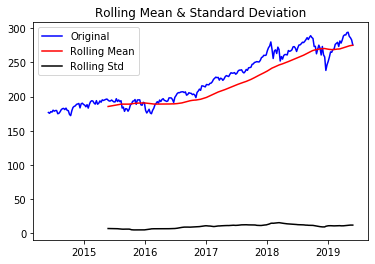

Results of Dickey-Fuller Test:
Test Statistic                  -0.693766
p-value                          0.848358
#Lags Used                       1.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [31]:
stationarity_test(data_ivv['IVV adjusted close'])

#p-value = 0.848 > 0.05 
#fail to reject Ho
#Time series is non-stationary

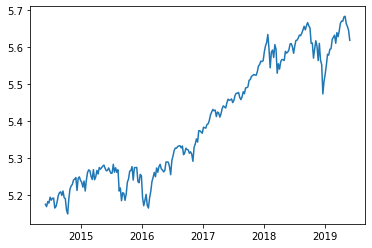

In [32]:
#log transformation on data
data_ivv_log = np.log(data_ivv_df)
plt.plot(data_ivv_log)

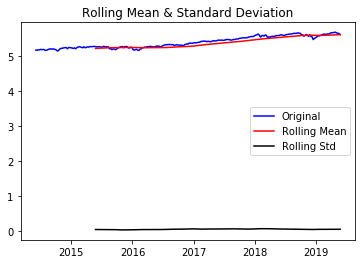

Results of Dickey-Fuller Test:
Test Statistic                  -0.813114
p-value                          0.815240
#Lags Used                       1.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [35]:
#check stationarity after nonlinear log transformation
stationarity_test(data_ivv_log['IVV adjusted close'])


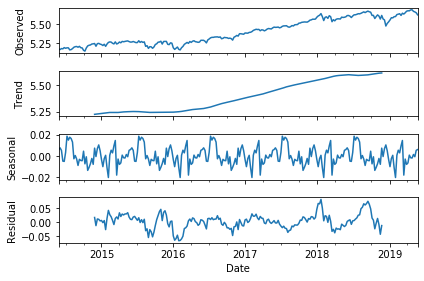

<Figure size 1440x720 with 0 Axes>

In [22]:
#Seasonality & decompo
decomposition = sm.tsa.seasonal_decompose(data_ivv_log)
fig = decomposition.plot()
plt.figure(figsize=(20, 10))
plt.show()

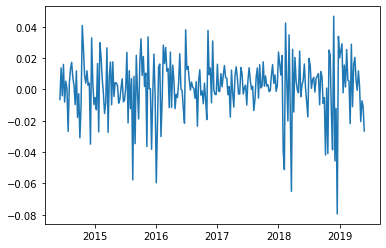

In [23]:
#Differencing
data_ivv_log_diff = data_ivv_log - data_ivv_log.shift()
plt.plot(data_ivv_log_diff)

In [24]:
lag_acf = acf(data_ivv_log, nlags=100)
lag_pacf = pacf(data_ivv_log, nlags=100, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

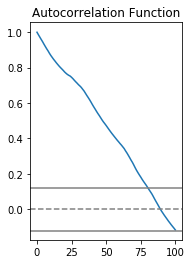

In [25]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_ivv_log_diff)),linestyle='-',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_ivv_log_diff)),linestyle='-',color='gray')
plt.title('Autocorrelation Function')

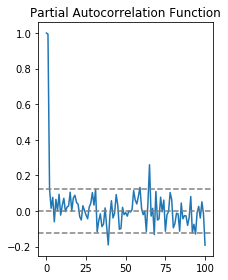

In [26]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_ivv_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_ivv_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

ValueError: Cannot add integral value to Timestamp without freq.

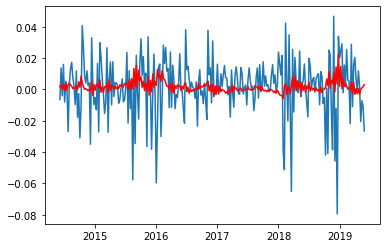

In [27]:
model = ARIMA(data_ivv_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(data_ivv_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-data_ivv_log_diff)**2))

In [ ]:
#Un-log

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

In [ ]:
predictions_ARIMA_log = pd.Series(data_ivv_log.ix[0], index=data_ivv_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_ivv)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data_ivv)**2)/len(data_ivv)))

In [37]:
size = int(len(data_ivv_log) - 15)
train, test = data_ivv_log[0:size], data_ivv_log[size:len(data_ivv_log)]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(5,1,10))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Euro Rate = %f, Expected Euro Rate = %f' % (np.exp(yhat), np.exp(observed)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

euro_predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...




ValueError: Insufficient degrees of freedom to estimate